In [13]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from gensim import corpora, models
from gensim.utils import simple_preprocess

In [2]:
df= pd.read_csv('Reviews.csv')

In [5]:
print(df.info())
print(df.describe())
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [10]:
df = df.sample(n=100000, random_state=42)

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [17]:
df.dropna(inplace=True)

# Drop duplicate reviews based on UserId, ProductId, and Time
df.drop_duplicates(subset=['UserId', 'ProductId', 'Time'], keep='first', inplace=True)

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)


In [18]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Manas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Manas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Manas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [19]:
# Define text preprocessing function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [20]:
def preprocess_text(text):
    # Remove punctuation and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = text.split()
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join tokens back into a single string
    return ' '.join(tokens)

In [21]:
# Applying preprocessing to the reviews
df['CleanedText'] = df['Text'].apply(preprocess_text)

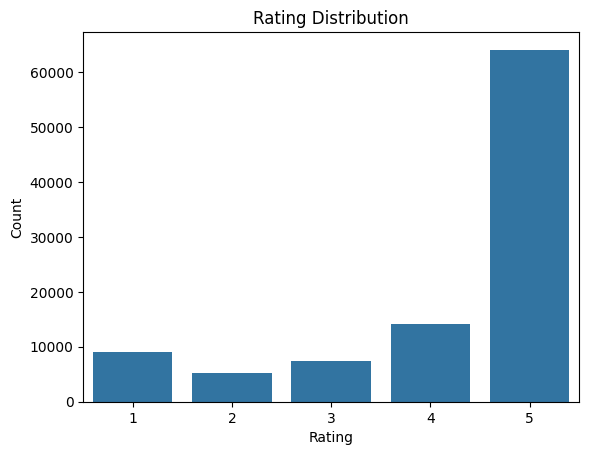

In [22]:
## 4. Exploratory Data Analysis (EDA)
# Distribution of ratings
sns.countplot(x='Score', data=df)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


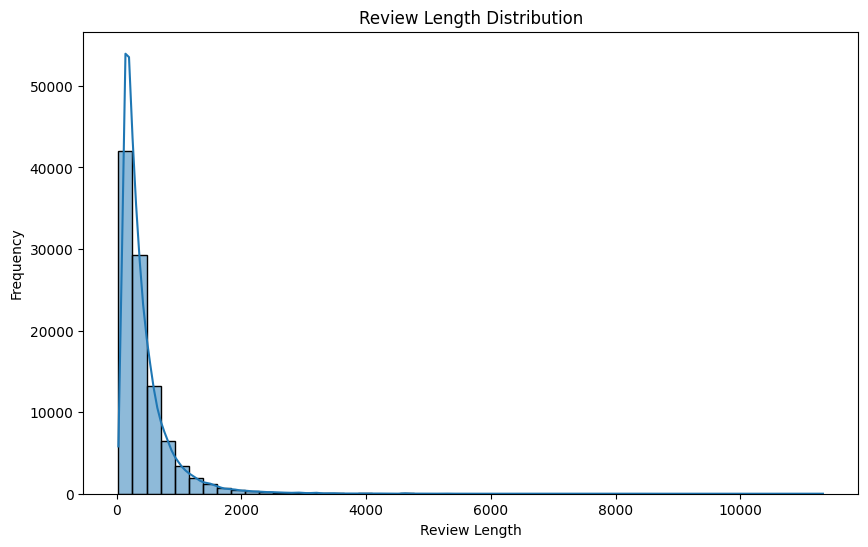

In [23]:
# Review Length Analysis
df['ReviewLength'] = df['Text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['ReviewLength'], bins=50, kde=True)
plt.title('Review Length Distribution')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()


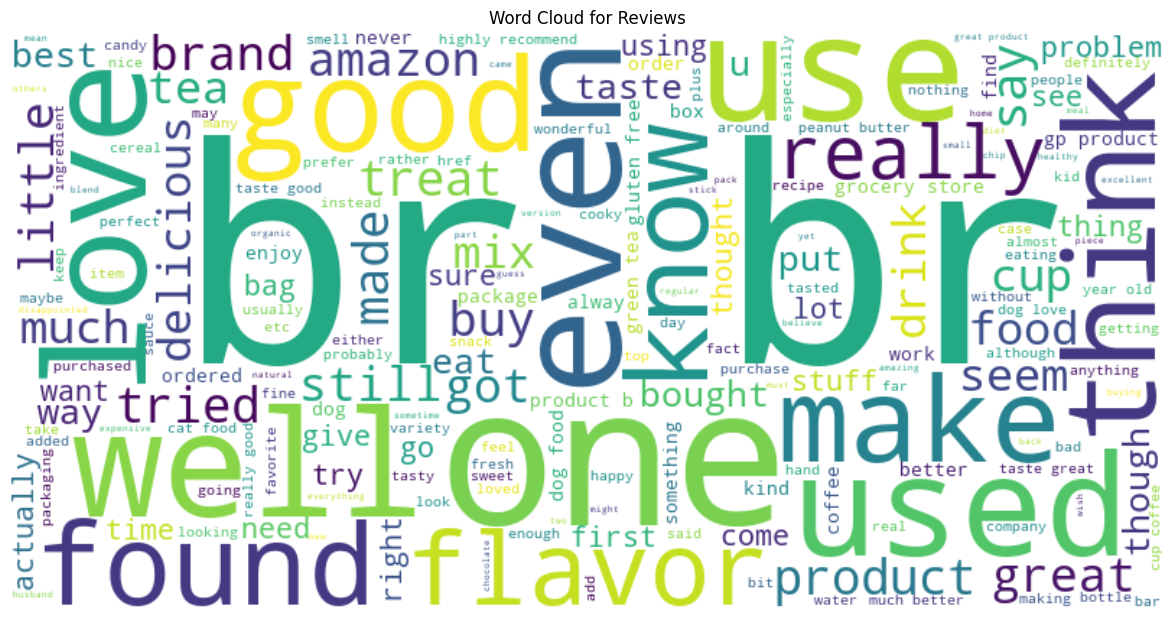

In [24]:
# Generate word cloud for all reviews
all_text = ' '.join(df['CleanedText'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Reviews')
plt.show()

In [25]:
### 5.1 Applying Sentiment Analysis Using VADER

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    score = sia.polarity_scores(text)
    return score['compound']

# Apply sentiment scoring
df['SentimentScore'] = df['CleanedText'].apply(get_sentiment_score)


In [27]:
# Classify sentiments based on scores
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'


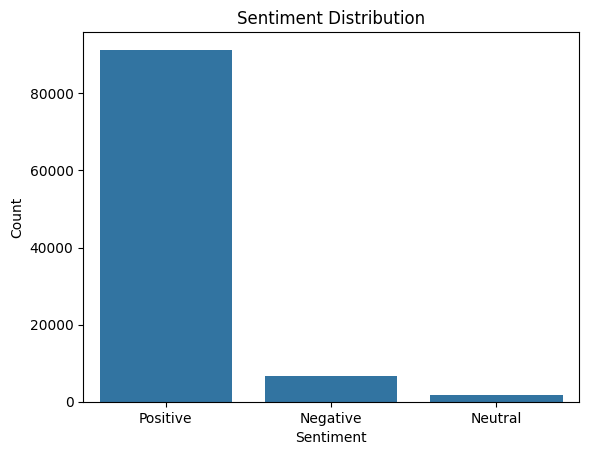

In [28]:
df['Sentiment'] = df['SentimentScore'].apply(classify_sentiment)

# Plot sentiment distribution
sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [29]:
### 5.2 Topic Modeling (Optional)

# Tokenize the cleaned text
df['Tokens'] = df['CleanedText'].apply(lambda x: simple_preprocess(x))

# Create Dictionary
dictionary = corpora.Dictionary(df['Tokens'])

# Create Corpus
corpus = [dictionary.doc2bow(text) for text in df['Tokens']]

# Build LDA Model
lda_model = models.LdaMulticore(corpus, num_topics=5, id2word=dictionary, passes=10, workers=2)


In [30]:
# Print the keywords in the topics
topics = lda_model.print_topics()
for idx, topic in topics:
    print(f'Topic #{idx}: {topic}\n')


Topic #0: 0.038*"tea" + 0.018*"flavor" + 0.018*"like" + 0.017*"taste" + 0.014*"chocolate" + 0.013*"good" + 0.011*"love" + 0.010*"chip" + 0.010*"one" + 0.010*"bag"

Topic #1: 0.023*"food" + 0.022*"br" + 0.021*"dog" + 0.012*"cat" + 0.012*"treat" + 0.010*"one" + 0.010*"love" + 0.009*"product" + 0.008*"like" + 0.007*"get"

Topic #2: 0.033*"br" + 0.011*"product" + 0.011*"great" + 0.010*"good" + 0.010*"taste" + 0.009*"free" + 0.009*"like" + 0.008*"food" + 0.008*"sugar" + 0.008*"eat"

Topic #3: 0.037*"coffee" + 0.019*"amazon" + 0.016*"cup" + 0.014*"price" + 0.013*"br" + 0.013*"product" + 0.012*"great" + 0.011*"good" + 0.011*"store" + 0.010*"like"

Topic #4: 0.058*"br" + 0.014*"taste" + 0.014*"like" + 0.012*"water" + 0.011*"flavor" + 0.008*"use" + 0.008*"product" + 0.007*"make" + 0.007*"good" + 0.007*"drink"



In [31]:
# Convert 'Time' column to datetime format
df['Date'] = pd.to_datetime(df['Time'], unit='s')

# Aggregate sentiment scores over time (monthly)
sentiment_over_time = df.groupby(df['Date'].dt.to_period('M'))['SentimentScore'].mean()


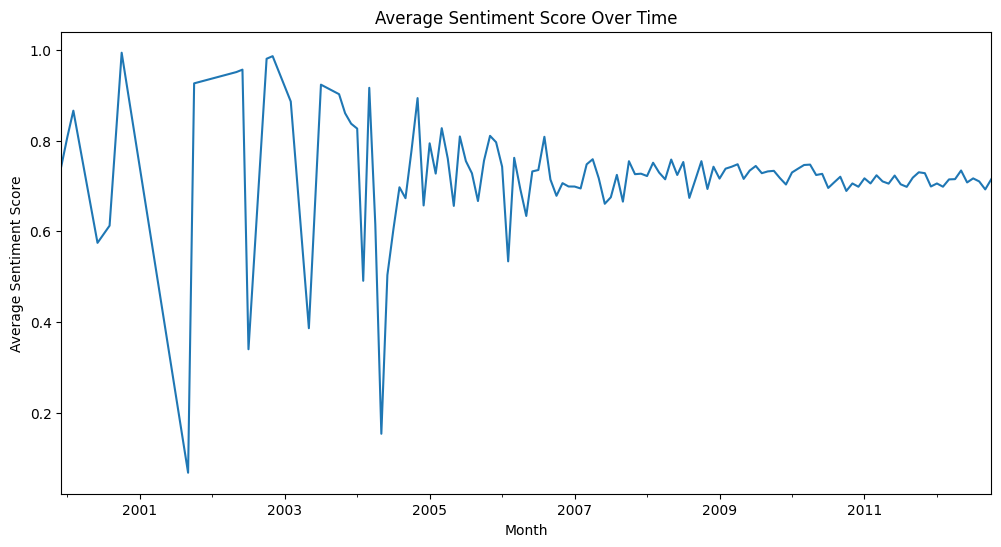

In [32]:
# Plot sentiment trends over time
sentiment_over_time.plot(kind='line', figsize=(12, 6))
plt.title('Average Sentiment Score Over Time')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.show()


In [33]:
# Summary of sentiment analysis
positive_reviews = len(df[df['Sentiment'] == 'Positive'])
negative_reviews = len(df[df['Sentiment'] == 'Negative'])
neutral_reviews = len(df[df['Sentiment'] == 'Neutral'])

print(f'Total Positive Reviews: {positive_reviews}')
print(f'Total Negative Reviews: {negative_reviews}')
print(f'Total Neutral Reviews: {neutral_reviews}')

Total Positive Reviews: 91301
Total Negative Reviews: 6722
Total Neutral Reviews: 1805
